In [1]:
import numpy as np
from scipy.special import expit
import sys
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import scipy.io

%matplotlib inline  

In [105]:
def symmetrize2D(field,dim=0):
    field_sym = field.copy()

    field_sym[0:int(np.floor(field.shape[dim]/2)),:] = (field[0:int(np.floor(field.shape[dim]/2)),:] + field[field.shape[dim]:int(np.ceil(field.shape[dim]/2))-1:-1,:])/2
    field_sym[int(np.ceil(field.shape[dim]/2)):field.shape[dim],:] = field_sym[int(np.floor(field.shape[dim]/2))-1::-1,:]
    return field_sym

#For v we need to subtract the two hemispheres... 
def antisymmetrize2D(field,dim=0):
    field_sym = field.copy()

    field_sym[0:int(np.floor(field.shape[dim]/2)),:] = -(field[0:int(np.floor(field.shape[dim]/2)),:] - field[field.shape[dim]:int(np.ceil(field.shape[dim]/2))-1:-1,:])/2
    field_sym[int(np.ceil(field.shape[dim]/2)):field.shape[dim],:] = field_sym[int(np.floor(field.shape[dim]/2))-1::-1,:]
    return field_sym


# def antisymmetrize2D(field,dim=0):
#     field_sym = field.copy()
#     return field_sym
# def symmetrize2D(field,dim=0):
#     field_sym = field.copy()
#     return field_sym

In [106]:
def symmetrize(field,dim=0):
    field_sym = field.copy()

    field_sym[0:int(np.floor(field.shape[dim]/2))] = (field[0:int(np.floor(field.shape[dim]/2))] + field[field.shape[dim]:int(np.ceil(field.shape[dim]/2))-1:-1])/2
    field_sym[int(np.ceil(field.shape[dim]/2)):field.shape[dim]] = field_sym[int(np.floor(field.shape[dim]/2))-1::-1]
    return field_sym

In [107]:
def read_nc_climatology(online_data_path):
    f_online = Dataset(online_data_path, mode='r')
    gr = 9.81 # gravity acceleration
    climatology_dict = dict()
    qv_ctl = f_online.variables['QV'][:]
    qc_ctl = f_online.variables['QC'][:]
    qi_ctl = f_online.variables['QI'][:]
    climatology_dict['QT'] = symmetrize2D(qv_ctl + qc_ctl + qi_ctl)#Non-precip water


    climatology_dict['T'] = symmetrize2D(f_online.variables['T'][:])

    climatology_dict['U'] = symmetrize2D(f_online.variables['U'][:])
    climatology_dict['V'] = antisymmetrize2D(f_online.variables['V'][:])
    climatology_dict['W'] = symmetrize2D(f_online.variables['W'][:])

    u2_ctl = f_online.variables['U2'][:]
    v2_ctl = f_online.variables['V2'][:]
    w2_ctl = f_online.variables['W2'][:]
    
    p = f_online.variables['P'][:]
    climatology_dict['EKE'] = symmetrize2D(u2_ctl + v2_ctl+ w2_ctl- f_online.variables['U'][:]**2- f_online.variables['V'][:]**2 - f_online.variables['W'][:]**2)
    climatology_dict['PRECIP'] = symmetrize(f_online.variables['precip_avg_rf'][:])
    climatology_dict['STRM_FC'] = antisymmetrize2D(calc_stream_fc(f_online.variables['V'][:],p))/gr
    climatology_dict['y'] = f_online.variables['y'][:]
    climatology_dict['p'] = f_online.variables['P'][:]
    f_online.close()
    
    return climatology_dict

In [108]:
def read_high_res(file_highres,online_data_path,p):
    x8_hires = dict()
    mat_dict_highres = scipy.io.loadmat(file_highres)
    x8_hires['V'] = antisymmetrize2D(mat_dict_highres['v_avg'].T)
    x8_hires['U'] = symmetrize2D(mat_dict_highres['u_avg'].T)
    x8_hires['W'] = symmetrize2D(mat_dict_highres['w_avg'].T)
    w2_avg = mat_dict_highres['w2_avg'].T
    u2_avg = mat_dict_highres['u2_avg'].T
    v2_avg = mat_dict_highres['v2_avg'].T
    x8_hires['T'] = symmetrize2D(mat_dict_highres['temp_avg'].T)
    qv_avg = mat_dict_highres['qv_avg'].T
    qi_avg = mat_dict_highres['qi_avg'].T
    qc_avg = mat_dict_highres['qc_avg'].T
#     p = mat_dict_highres['pressure']
    x8_hires['QT'] = symmetrize2D(qv_avg + qi_avg + qc_avg) # Non precipitating water

    x8_hires['EKE'] = symmetrize2D(v2_avg  + u2_avg + w2_avg -mat_dict_highres['v_avg'].T**2 -mat_dict_highres['u_avg'].T**2 -mat_dict_highres['w_avg'].T**2)

    x8_hires['STRM_FC'] = antisymmetrize2D(calc_stream_fc(mat_dict_highres['v_avg'].T,p))/gr

    f_online = Dataset(online_data_path, mode='r')
    x8_hires['PRECIP'] = symmetrize(f_online.variables['precip_avg_coarse'][:])
    f_online.close()

    return x8_hires

In [109]:
def calc_RMSE(dict1,dict2):
    for key in dict2.keys():
        dict1[key+'_RMSE'] = np.std(dict1[key] - dict2[key])
        dict1[key+'_RMSE_STR'] =  "{:.2f}".format(dict1[key+'_RMSE'])

In [110]:
def calc_r2(dict1,dict2):
    for key in dict2.keys():
        dict1[key+'_R2'] = r2_score(np.reshape(dict2[key],-1),np.reshape(dict1[key],-1))

In [111]:
def calc_stream_fc(v,p):
    stm_fc = np.zeros((v.shape[0],v.shape[1]-1))
    p_diff = p[0:-1] - p[1:]
    vmid = (v[:,0:-1] + v[:,1:])/2
    for i in range(1,stm_fc.shape[1]+1):
        stm_fc[:,i-1] = np.sum(vmid[:,0:i]*p_diff[None,0:i], axis=1)
    return stm_fc
    

In [112]:
dir_data = '/Users/yani/Dropbox/MIT/projects/ML_momentum_data/data_online_plots_production'

# On the github these files are in data_online directory:


path_ref_x4 = dir_data + '/data_x4_reference/nc_stat.nc'
path_NN_x4  = dir_data + '/data_x4_5_layers/nc_stat.nc'
path_MOM_x4 = dir_data + '/data_x4_5layer_with_momentum_with_tkz_before_adams/nc_stat.nc'
file_highres_x4 = dir_data + '/12km_diff_coarse_space_corrected_tkz4_statistics.mat'

path_ref_x8 = dir_data + '/data_x8_reference/nc_stat.nc'
path_NN_x8  = dir_data + '/data_x8_5_layers/nc_stat.nc'
path_MOM_x8 = dir_data + '/data_x8_5layer_with_momentum_with_tkz_before_adams/nc_stat.nc'
file_highres_x8 = dir_data + '/12km_diff_coarse_space_corrected_tkz8_statistics.mat'


gr = 9.81 # gravity acceleration




In [113]:

x4_reference = read_nc_climatology(path_ref_x4)
x4_NN = read_nc_climatology(path_NN_x4)
x4_MOM = read_nc_climatology(path_MOM_x4)
x4_hires = read_high_res(file_highres_x4,path_ref_x4,p = x4_reference['p'])

x8_reference = read_nc_climatology(path_ref_x8)
x8_NN = read_nc_climatology(path_NN_x8)
x8_MOM = read_nc_climatology(path_MOM_x8)
x8_hires = read_high_res(file_highres_x8,path_ref_x8,p = x4_reference['p'])

In [101]:
colors1 = ['C0','C1','C2']



# Comparing EKE U V to reference x8 - To Get RSQ

In [114]:
calc_RMSE(x4_reference,x4_hires)
calc_RMSE(x4_NN,x4_hires)
calc_RMSE(x4_MOM,x4_hires)


calc_r2(x4_reference,x4_hires)
calc_r2(x4_NN,x4_hires)
calc_r2(x4_MOM,x4_hires)


calc_RMSE(x8_reference,x8_hires)
calc_RMSE(x8_NN,x8_hires)
calc_RMSE(x8_MOM,x8_hires)


calc_r2(x8_reference,x8_hires)
calc_r2(x8_NN,x8_hires)
calc_r2(x8_MOM,x8_hires)


In [13]:
RMSE_keys = ['QT_RMSE', 'T_RMSE', 'U_RMSE', 'V_RMSE', 'W_RMSE', 'EKE_RMSE', 'PRECIP_RMSE', 'STRM_FC_RMSE']
print('x8-REF')
for key in RMSE_keys:
    print(key + ':   ' + str(np.mean(x8_reference[key])))
    
print('x8-NN')
for key in RMSE_keys:
    print(key + ':   ' + str(np.mean(x8_NN[key])))

print('x8-MOM')
for key in RMSE_keys:
    print(key + ':   ' + str(np.mean(x8_MOM[key])))


x8-REF
QT_RMSE:   0.00016312432013022596
T_RMSE:   3.0468619934343053
U_RMSE:   3.2076793965855495
V_RMSE:   0.24886725632808376
W_RMSE:   0.0007928688332930802
EKE_RMSE:   34.9082146306116
PRECIP_RMSE:   0.7073667022983362
STRM_FC_RMSE:   2.17301412910925
x8-NN
QT_RMSE:   0.00016312432013022596
T_RMSE:   3.0468619934343053
U_RMSE:   3.2076793965855495
V_RMSE:   0.24886725632808376
W_RMSE:   0.0007928688332930802
EKE_RMSE:   34.9082146306116
PRECIP_RMSE:   0.7073667022983362
STRM_FC_RMSE:   2.17301412910925
x8-MOM
QT_RMSE:   0.00013282060137762808
T_RMSE:   2.728039671373753
U_RMSE:   2.715683793954434
V_RMSE:   0.16506621899983162
W_RMSE:   0.0005739253128173507
EKE_RMSE:   34.697966339638
PRECIP_RMSE:   0.44321822946473943
STRM_FC_RMSE:   1.3618444796142999


In [14]:
RMSE_keys = ['QT_RMSE', 'T_RMSE', 'U_RMSE', 'V_RMSE', 'W_RMSE', 'EKE_RMSE', 'PRECIP_RMSE', 'STRM_FC_RMSE']
print('x4-REF')
for key in RMSE_keys:
    print(key + ':   ' + str(np.mean(x4_reference[key])))
    
print('x4-NN')
for key in RMSE_keys:
    print(key + ':   ' + str(np.mean(x4_NN[key])))

print('x4-MOM')
for key in RMSE_keys:
    print(key + ':   ' + str(np.mean(x4_MOM[key])))


x4-REF
QT_RMSE:   0.00047701835716126276
T_RMSE:   4.220272250925386
U_RMSE:   4.476839341035962
V_RMSE:   0.6596151656653884
W_RMSE:   0.004016133629321954
EKE_RMSE:   41.691167333211276
PRECIP_RMSE:   4.809148041185706
STRM_FC_RMSE:   9.866985906061874
x4-NN
QT_RMSE:   0.00016261609201834732
T_RMSE:   4.539333861216919
U_RMSE:   2.6996391133162816
V_RMSE:   0.20838853429961224
W_RMSE:   0.0006754864720990428
EKE_RMSE:   28.22376376768089
PRECIP_RMSE:   0.39576839617879334
STRM_FC_RMSE:   2.084924566292972
x4-MOM
QT_RMSE:   0.00021934160120896728
T_RMSE:   4.222155096998805
U_RMSE:   2.8584238426014488
V_RMSE:   0.23022442144305186
W_RMSE:   0.0012260718033707577
EKE_RMSE:   34.228281684130415
PRECIP_RMSE:   1.131856404516311
STRM_FC_RMSE:   3.222230676091044


In [18]:
from matplotlib import cm
def plot_RMSE_plot_U_V_2_resolutions_3_panels_1_hemisphere(dict_hires1,dict_lowres1,dict_NN1,dict_NN_mom1,y,p,
                  dict_hires2,dict_lowres2,dict_NN2,dict_NN_mom2,y2,p2,fields_list=list(),save_name='dummy',save=False,
                                                          lat_x4 = 180, lat_x8 = 90):
    dict_hires = dict_hires1
    dict_lowres = dict_lowres1
    dict_NN = dict_NN1
    dict_NN_mom = dict_NN_mom1
    res_sim = 'X4'
    res_sim2 = 'X8'
    fontsize = 20
    fontsize_cont1 = 19
    rescale_W = 100
    y_plot1 = (y - np.mean(y))/10**6
    
    y_plot2 = (y2 - np.mean(y2))/10**6

    x_ticks_lon = [-2,0,2]
    ticks_lat = [0,5]
    ticks_press = [900,600,300]

    cont_min_dqp = -0.0004
    cont_max_dqp = 0.0004
    lev_dqp = np.arange(cont_min_dqp, cont_max_dqp, 0.00005)

    lev_Rsq = np.arange(-0.1, 1.01, 0.1)
    cont_min_rsq = 0
    cont_max_rsq = 1

    h_width = 0.1
    v_width = 0.1
    h_width_cbar = 0.02

    colorbar_width =0.02

    p_lev_rad = 26
    p_lev_diff = 15

    row_dim = 4
    col_dim = 3

    # field_to_plot = list()
    # field_to_plot.extend()

    fig_witdth = 0.3
    fig_height = 0.3
    fig_h_dist = 0.02
    fig_h_dist_first = 0.08
    fig_v_dist = 0.08

#     letters = ["(a)             hi-res","(b)      x4-NN - hi-res","(c)     x4-MOM - hi-res","(d)    x4-MOM - x4-NN","(e)","(f)","(g)","(h)","(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)"]                
    
    
    letters = ["(a) hi-res (coarse to x4)","(b)      x4-NN - hi-res","(c)    x4-MOM - x4-NN",
               "(d)","(e)","(f)",
               "(g) hi-res (coarse to x8)","(h)      x8-NN - hi-res","(i)    x8-MOM - x8-NN",
               "(j)","(k)","(l)","(m)"]                

    
    num_of_levs = 20
#     EKE_diff = 230# + 200/num_of_levs
#     PRECIP_diff = 2
    U_diff = 10#+ 20/num_of_levs
    V_diff = 2#+ 5/num_of_levs
#     W_diff = 0.01 * rescale_W #+ 5/num_of_levs 
#     # QV_diff = 0.005#+ 0.01/num_of_levs
#     QV_diff = 200#+ 0.01/num_of_levs


    # num_of_levs = 20
#     lev_EKE = np.arange(0, np.max(dict_hires['EKE']) + 100, (np.max(dict_hires['EKE'])/num_of_levs)
#     lev_EKE2 = np.arange(-EKE_diff,EKE_diff+0.001,EKE_diff/num_of_levs)
    
#     lev_PRECIP = np.arange(0, np.max(dict_hires['PRECIP']) + 2, (np.max(dict_hires['PRECIP']))/num_of_levs)
#     lev_PRECIP2 = np.arange(-PRECIP_diff,PRECIP_diff+0.001,EKE_diff/num_of_levs)
    
    lev_U = np.arange(-np.max(dict_hires['U']), np.max(dict_hires['U'])+1, (np.max(dict_hires['U']))/num_of_levs)
    lev_U2 = np.arange(-U_diff,U_diff+0.001,U_diff/num_of_levs)
    lev_V = np.arange(np.min(dict_hires['V']), -np.min(dict_hires['V']), (np.max(dict_hires['V']))/num_of_levs)
    lev_V2 = np.arange(-V_diff,V_diff+0.001,V_diff/num_of_levs)
                    
        
#     lev_V = np.arange(np.min(dict_hires['V']), -np.min(dict_hires['V']), (np.max(dict_hires['V']))/num_of_levs)
#     lev_V2 = np.arange(-V_diff,V_diff+0.001,V_diff/num_of_levs)
                                                                               
#     lev_W = np.arange(-np.max(dict_hires['W']* rescale_W), np.max(dict_hires['W']* rescale_W), (np.max(dict_hires['W']* rescale_W))/num_of_levs)
#     lev_W2 = np.arange(-W_diff,W_diff+0.001,W_diff/num_of_levs)


#                     
#     lev_QV = np.arange(np.min(stm_fc_avg12km_sym), np.max(stm_fc_avg12km_sym), (np.max(stm_fc_avg12km_sym))/num_of_levs)
#     lev_QV2 = np.arange(-QV_diff,QV_diff+0.001,QV_diff/num_of_levs)




    fig, axes = plt.subplots(row_dim,col_dim,figsize=(10, 8))

    cmap11 = cm.bwr
    

         
    y_plot = y_plot1[lat_x4:]

    row1 = 0
    cax_U_1 = axes[row1, 0].contourf(y_plot, p, dict_hires['U'][lat_x4:,:].T,lev_U,cmap=cm.bwr)#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
    axes[row1, 0].set_ylim(np.amax(p), np.amin(p))

    cax_T_Rsq = axes[row1, 1].contourf(y_plot, p, dict_NN['U'][lat_x4:,:].T-dict_hires['U'][lat_x4:,:].T,lev_U2,cmap=cmap11,extend ='both')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
    axes[row1, 1].set_ylim(np.amax(p), np.amin(p))


#     cax_U = axes[row1, 2].contourf(y_plot, p, dict_NN_mom['U'].T-dict_hires['U'].T,lev_U2,cmap=cmap11,extend ='both')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
#     axes[row1, 2].set_ylim(np.amax(p), np.amin(p))

    cax_U = axes[row1, 2].contourf(y_plot, p, dict_NN_mom['U'][lat_x4:,:].T-dict_NN['U'][lat_x4:,:].T,lev_U2,cmap=cmap11,extend ='both')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
    axes[row1, 2].set_ylim(np.amax(p), np.amin(p))
                                                                               
    row1 = 1
    cax_V_1 = axes[row1, 0].contourf(y_plot, p, dict_hires['V'][lat_x4:,:].T,lev_V,cmap=cm.bwr)#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
    axes[row1, 0].set_ylim(np.amax(p), np.amin(p))


    cax_T_Rsq = axes[row1, 1].contourf(y_plot, p, dict_NN['V'][lat_x4:,:].T-dict_hires['V'][lat_x4:,:].T,lev_V2,cmap=cmap11,extend ='both')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
    axes[row1, 1].set_ylim(np.amax(p), np.amin(p))

#     cax_V = axes[row1, 2].contourf(y_plot, p, dict_NN_mom['V'].T-dict_hires['V'].T,lev_V2,cmap=cmap11,extend ='both')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
#     axes[row1, 2].set_ylim(np.amax(p), np.amin(p))

    cax_V = axes[row1, 2].contourf(y_plot, p, dict_NN_mom['V'][lat_x4:,:].T-dict_NN['V'][lat_x4:,:].T,lev_V2,cmap=cmap11,extend ='both')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
    axes[row1, 2].set_ylim(np.amax(p), np.amin(p))
                                                                               

    dict_hires = dict_hires2
    dict_lowres = dict_lowres2
    dict_NN = dict_NN2
    dict_NN_mom = dict_NN_mom2
    y_plot = y_plot2[lat_x8:]
    row1 = 2
    cax_U_2 = axes[row1, 0].contourf(y_plot, p, dict_hires['U'][lat_x8:,:].T,lev_U,cmap=cm.bwr)#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
    axes[row1, 0].set_ylim(np.amax(p), np.amin(p))

    cax_T_Rsq2 = axes[row1, 1].contourf(y_plot, p, dict_NN['U'][lat_x8:,:].T-dict_hires['U'][lat_x8:,:].T,lev_U2,cmap=cmap11,extend ='both')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
    axes[row1, 1].set_ylim(np.amax(p), np.amin(p))


#     cax_U2 = axes[row1, 2].contourf(y_plot, p, dict_NN_mom['U'].T-dict_hires['U'].T,lev_U2,cmap=cmap11,extend ='both')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
#     axes[row1, 2].set_ylim(np.amax(p), np.amin(p))

    cax_U2 = axes[row1, 2].contourf(y_plot, p, dict_NN_mom['U'][lat_x8:,:].T-dict_NN['U'][lat_x8:,:].T,lev_U2,cmap=cmap11,extend ='both')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
    axes[row1, 2].set_ylim(np.amax(p), np.amin(p))
                                                                               

    row1 = 3
    cax_V_2 = axes[row1, 0].contourf(y_plot, p, dict_hires['V'][lat_x8:,:].T,lev_V,cmap=cm.bwr)#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
    axes[row1, 0].set_ylim(np.amax(p), np.amin(p))


    cax_T_Rsq2 = axes[row1, 1].contourf(y_plot, p, dict_NN['V'][lat_x8:,:].T-dict_hires['V'][lat_x8:,:].T,lev_V2,cmap=cmap11,extend ='both')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
    axes[row1, 1].set_ylim(np.amax(p), np.amin(p))

#     cax_V2 = axes[row1, 2].contourf(y_plot, p, dict_NN_mom['V'].T-dict_hires['V'].T,lev_V2,cmap=cmap11,extend ='both')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
#     axes[row1, 2].set_ylim(np.amax(p), np.amin(p))

    cax_V2 = axes[row1, 2].contourf(y_plot, p, dict_NN_mom['V'][lat_x8:,:].T-dict_NN['V'][lat_x8:,:].T,lev_V2,cmap=cmap11,extend ='both')#,vmin=cont_min_rsq, vmax=cont_max_rsq)#,cmap='seismic')
    axes[row1, 2].set_ylim(np.amax(p), np.amin(p))
                    

    #Position of first figure        
    x0 = axes[0,0].get_position().x0
    x1 = axes[0,0].get_position().x1
    y0 = axes[0,0].get_position().y0
    y1 = axes[0,0].get_position().y1

    for i in range(row_dim):
        for j  in range(col_dim):
            if (i+1)*(j+1) > len(letters):
                continue
            if j > 0:
                axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist + fig_h_dist_first,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])
            else:
                axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])




    i = 0
    j = 2 
    cbaxes_rsq = fig.add_axes([axes[i, j].get_position().x0+axes[i, j].get_position().width + h_width_cbar, axes[i, j].get_position().y0, colorbar_width, fig_height]) 
    cbar_rsq = fig.colorbar(cax_U,cax = cbaxes_rsq,ticks=lev_U2[::10],ax=axes[i, j])#,cax = cbaxes_rsq, ax=axes[0:2, :], shrink=1.0,ticks=np.arange(cont_min_rsq, cont_max_rsq, cont_max_rsq/4),)
    cbar_rsq.set_ticklabels(lev_U2[::10].astype(int))
    # cbar_rsq.set_label('[$m/s$]',fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize)
    

    i = 1
    j = 2
    cbaxes_rsq = fig.add_axes([axes[i, j].get_position().x0+axes[i, j].get_position().width + h_width_cbar, axes[i, j].get_position().y0, colorbar_width, fig_height]) 
    cbar_rsq = fig.colorbar(cax_V,cax = cbaxes_rsq,ticks=lev_V2[::10],ax=axes[i, j])#,cax = cbaxes_rsq, ax=axes[0:2, :], shrink=1.0,ticks=np.arange(cont_min_rsq, cont_max_rsq, cont_max_rsq/4),)
    cbar_rsq.set_ticklabels(lev_V2[::10].astype(int))
    # cbar_rsq.set_label('[$m/s$]',fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize)

    i = 2
    j = 2
    cbaxes_rsq = fig.add_axes([axes[i, j].get_position().x0+axes[i, j].get_position().width + h_width_cbar, axes[i, j].get_position().y0, colorbar_width, fig_height]) 
    cbar_rsq = fig.colorbar(cax_U2,cax = cbaxes_rsq,ticks=lev_U2[::10],ax=axes[i, j])#,cax = cbaxes_rsq, ax=axes[0:2, :], shrink=1.0,ticks=np.arange(cont_min_rsq, cont_max_rsq, cont_max_rsq/4),)
    cbar_rsq.set_ticklabels(lev_U2[::10].astype(int))
    # cbar_rsq.set_label('[$m/s$]',fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize)

    i = 3
    j = 2 
    cbaxes_rsq = fig.add_axes([axes[i, j].get_position().x0+axes[i, j].get_position().width + h_width_cbar, axes[i, j].get_position().y0, colorbar_width, fig_height]) 
    cbar_rsq = fig.colorbar(cax_V2,cax = cbaxes_rsq,ticks=lev_V2[::10],ax=axes[i, j])#,cax = cbaxes_rsq, ax=axes[0:2, :], shrink=1.0,ticks=np.arange(cont_min_rsq, cont_max_rsq, cont_max_rsq/4),)
    cbar_rsq.set_ticklabels(lev_V2[::10].astype(int))
    # cbar_rsq.set_label('[$m/s$]',fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize)



    i = 0
    j = 0
    lev_U2_ticks = [-40,-20,0,20,40]
    cbaxes_rsq = fig.add_axes([axes[i, j].get_position().x0+axes[i, j].get_position().width + h_width_cbar, axes[i, j].get_position().y0, colorbar_width, fig_height]) 
    cbar_rsq = fig.colorbar(cax_U_1,cax = cbaxes_rsq,ticks=lev_U2_ticks,ax=axes[i, j])#,cax = cbaxes_rsq, ax=axes[0:2, :], shrink=1.0,ticks=np.arange(cont_min_rsq, cont_max_rsq, cont_max_rsq/4),)
    cbar_rsq.set_ticklabels(lev_U2_ticks)
    # cbar_rsq.set_label('[$m/s$]',fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize)
    
    i = 1
    j = 0 
    lev_V2_ticks = [-4,-2,0,2,4,6]
    cbaxes_rsq = fig.add_axes([axes[i, j].get_position().x0+axes[i, j].get_position().width + h_width_cbar, axes[i, j].get_position().y0, colorbar_width, fig_height]) 
    cbar_rsq = fig.colorbar(cax_V_1,cax = cbaxes_rsq,ticks=lev_V2_ticks,ax=axes[i, j])#,cax = cbaxes_rsq, ax=axes[0:2, :], shrink=1.0,ticks=np.arange(cont_min_rsq, cont_max_rsq, cont_max_rsq/4),)
    cbar_rsq.set_ticklabels(lev_V2_ticks)
    # cbar_rsq.set_label('[$m/s$]',fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize)

    
    i = 2
    j = 0
    lev_U2_ticks = [-40,-20,0,20,40]
    cbaxes_rsq = fig.add_axes([axes[i, j].get_position().x0+axes[i, j].get_position().width + h_width_cbar, axes[i, j].get_position().y0, colorbar_width, fig_height]) 
    cbar_rsq = fig.colorbar(cax_U_2,cax = cbaxes_rsq,ticks=lev_U2_ticks,ax=axes[i, j])#,cax = cbaxes_rsq, ax=axes[0:2, :], shrink=1.0,ticks=np.arange(cont_min_rsq, cont_max_rsq, cont_max_rsq/4),)
    cbar_rsq.set_ticklabels(lev_U2_ticks)
    # cbar_rsq.set_label('[$m/s$]',fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize)
    
    i = 3
    j = 0 
    lev_V2_ticks = [-4,-2,0,2,4,6]
    cbaxes_rsq = fig.add_axes([axes[i, j].get_position().x0+axes[i, j].get_position().width + h_width_cbar, axes[i, j].get_position().y0, colorbar_width, fig_height]) 
    cbar_rsq = fig.colorbar(cax_V_2,cax = cbaxes_rsq,ticks=lev_V2_ticks,ax=axes[i, j])#,cax = cbaxes_rsq, ax=axes[0:2, :], shrink=1.0,ticks=np.arange(cont_min_rsq, cont_max_rsq, cont_max_rsq/4),)
    cbar_rsq.set_ticklabels(lev_V2_ticks)
    # cbar_rsq.set_label('[$m/s$]',fontsize=fontsize)
    cbar_rsq.ax.tick_params(labelsize=fontsize)


    j = 2.1
    atext2 = axes[3, 2].text(axes[3,2].get_position().x0*0.72+ j*fig_witdth + j*fig_h_dist-0.03,axes[0,0].get_position().y0 + (1.0)*fig_height - (i-1)*fig_v_dist ,'zonal wind',transform = fig.transFigure,color="black",fontsize=fontsize)
    atext2 = axes[3, 2].text(axes[3,2].get_position().x0*0.72+ j*fig_witdth + j*fig_h_dist-0.03,axes[0,0].get_position().y0 +(0.8)*fig_height - (i-1)*fig_v_dist ,r'[m s$^{-1}$]',transform = fig.transFigure,color="black",fontsize=fontsize)

    atext2 = axes[3, 2].text(axes[3,2].get_position().x0*0.72+ j*fig_witdth + j*fig_h_dist-0.03,axes[1,0].get_position().y0 + (1.0)*fig_height - (i-1)*fig_v_dist ,'meridional wind',transform = fig.transFigure,color="black",fontsize=fontsize)
    atext2 = axes[3, 2].text(axes[3,2].get_position().x0*0.72+ j*fig_witdth + j*fig_h_dist-0.03,axes[1,0].get_position().y0 +(0.8)*fig_height - (i-1)*fig_v_dist ,r'[m s$^{-1}$]',transform = fig.transFigure,color="black",fontsize=fontsize)

    atext2 = axes[3, 2].text(axes[3,2].get_position().x0*0.72+ j*fig_witdth + j*fig_h_dist-0.03,axes[2,0].get_position().y0 + (1.0)*fig_height - (i-1)*fig_v_dist ,'zonal wind',transform = fig.transFigure,color="black",fontsize=fontsize)
    atext2 = axes[3, 2].text(axes[3,2].get_position().x0*0.72+ j*fig_witdth + j*fig_h_dist-0.03,axes[2,0].get_position().y0 +(0.8)*fig_height - (i-1)*fig_v_dist ,r'[m s$^{-1}$]',transform = fig.transFigure,color="black",fontsize=fontsize)

    
    atext2 = axes[3, 2].text(axes[3,2].get_position().x0*0.72+ j*fig_witdth + j*fig_h_dist-0.03,axes[3,0].get_position().y0 + (1.0)*fig_height - (i-1)*fig_v_dist ,'meridional wind',transform = fig.transFigure,color="black",fontsize=fontsize)
    atext2 = axes[3, 2].text(axes[3,2].get_position().x0*0.72+ j*fig_witdth + j*fig_h_dist-0.03,axes[3,0].get_position().y0 +(0.8)*fig_height - (i-1)*fig_v_dist ,r'[m s$^{-1}$]',transform = fig.transFigure,color="black",fontsize=fontsize)

    # atext2 = axes[3, 2].text(axes[3,2].get_position().x0*0.7+ j*fig_witdth + j*fig_h_dist-0.03,axes[3,0].get_position().y0 + (1.1)*fig_height - (i-1)*fig_v_dist ,'non-precipitating water',transform = fig.transFigure,color="black",fontsize=fontsize)
    # atext2 = axes[3, 2].text(axes[3,2].get_position().x0*0.7+ j*fig_witdth + j*fig_h_dist-0.03,axes[3,0].get_position().y0 +(0.9)*fig_height - (i-1)*fig_v_dist ,'[kg/kg x$10^{-2}$]',transform = fig.transFigure,color="black",fontsize=fontsize)


#     atext2 = axes[3, 2].text(axes[3,2].get_position().x0*0.7+ j*fig_witdth + j*fig_h_dist-0.03,axes[3,0].get_position().y0 + (1.1)*fig_height - (i-1)*fig_v_dist ,'mass streamfunction',transform = fig.transFigure,color="black",fontsize=fontsize)
#     atext2 = axes[3, 2].text(axes[3,2].get_position().x0*0.7+ j*fig_witdth + j*fig_h_dist-0.03,axes[3,0].get_position().y0 +(0.9)*fig_height - (i-1)*fig_v_dist ,'[hPa m/s]',transform = fig.transFigure,color="black",fontsize=fontsize)


    rescale_let_pos = 0.8
    lat_pos = min(y_plot)*(rescale_let_pos*1.1)
    # lon_pos = max(x_plot)*rescale_let_pos
    press_pos = 150
    press_pos2 = 300


    ind_let = 0
    for i in range(row_dim):
        for j  in range(col_dim):
            if (i+1)*(j+1) > len(letters):
                continue
            if j > 0:
                atext2 = axes[i, j].text(axes[0,0].get_position().x0*0.8+ j*fig_witdth + j*fig_h_dist+fig_h_dist_first,axes[0,0].get_position().y0*1.02- (i-1)*fig_height - i*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize-2)
            else:
                atext2 = axes[i, j].text(axes[0,0].get_position().x0*0.8+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*1.02- (i-1)*fig_height - i*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize-2)

#             header= axes[i, j].text(axes[0,0].get_position().x0*1.1+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.9- (i-1)*fig_height - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
            ind_let = ind_let + 1


    axes[2, 0].set_xlim(np.amin(y_plot), np.amax(y_plot))


    axes[0, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
    axes[1, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
    axes[2, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
    axes[3, 0].set_ylabel('Pressure [hPa]',fontsize=fontsize)
#     axes[3, 0].set_ylabel(r'Precipitation [mm day$^{-1}$]',fontsize=fontsize)


    axes[3, 0].set_xlabel('Latitude',fontsize=fontsize)
    axes[3, 1].set_xlabel('Latitude',fontsize=fontsize)
    axes[3, 2].set_xlabel('Latitude',fontsize=fontsize)
#     axes[3, 3].set_xlabel('Latitude',fontsize=fontsize)



    #Ticks and tick labels
    ticks_press_R2 = [0.2,0.4,0.6]
#     ticks_lat_degrees = ['$-45^\circ$','$0^\circ$','$45^\circ$']
    ticks_lat_degrees = ['$0^\circ$','$45^\circ$']
    axes[2, 0].set_yticks(ticks_press)
    axes[2, 0].set_yticklabels(ticks_press,fontsize=fontsize)
    axes[2, 1].set_yticks(ticks_press)
    axes[2, 1].set_yticklabels([])
    axes[2, 2].set_yticks(ticks_press)
    axes[2, 2].set_yticklabels([])
    
    axes[3, 0].set_yticks(ticks_press)
    axes[3, 0].set_yticklabels(ticks_press,fontsize=fontsize)
    axes[3, 1].set_yticks(ticks_press)
    axes[3, 1].set_yticklabels([])
    axes[3, 2].set_yticks(ticks_press)
    axes[3, 2].set_yticklabels([])
#     axes[3, 3].set_yticks(ticks_press)
#     axes[3, 3].set_yticklabels([])


    axes[0, 2].set_yticks(ticks_press)
    axes[0, 2].set_yticklabels([])

    axes[1, 2].set_yticks(ticks_press)
    axes[1, 2].set_yticklabels([])
    
    axes[3, 0].set_xticks(ticks_lat)
    axes[3, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize)
    axes[3, 1].set_xticks(ticks_lat)
    axes[3, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize)
    axes[3, 2].set_xticks(ticks_lat)
    axes[3, 2].set_xticklabels(ticks_lat_degrees,fontsize=fontsize)
#     axes[3, 3].set_xticks(ticks_lat)
#     axes[3, 3].set_xticklabels(ticks_lat_degrees,fontsize=fontsize)


    # axes[2, 1].set_xticks(ticks_lat)
    # axes[2, 1].set_xticklabels(ticks_lat,fontsize=fontsize)
    # axes[2, 1].set_yticks(x_ticks_lon)
    # axes[2, 1].set_yticklabels([])
    # axes[0, 0].set_xticks(ticks_lat)
    # axes[0, 0].set_xticklabels(ticks_lat,fontsize=fontsize)

    axes[1, 0].set_xticks(ticks_lat)
    axes[1, 0].set_xticklabels([])
    axes[0, 0].set_yticks(ticks_press)
    axes[0, 0].set_yticklabels(ticks_press,fontsize=fontsize)
    axes[0, 0].set_xticks(ticks_lat)
    axes[0, 0].set_xticklabels([])



    axes[2, 0].set_xticks(ticks_lat)
    axes[2, 0].set_xticklabels([])
    axes[2, 1].set_xticks(ticks_lat)
    axes[2, 1].set_xticklabels([])
    axes[2, 2].set_xticks(ticks_lat)
    axes[2, 2].set_xticklabels([])
#     axes[2, 3].set_xticks(ticks_lat)
#     axes[2, 3].set_xticklabels([])

    axes[1, 0].set_xticks(ticks_lat)
    axes[1, 0].set_xticklabels([])
    axes[1, 1].set_xticks(ticks_lat)
    axes[1, 1].set_xticklabels([])
    axes[1, 2].set_xticks(ticks_lat)
    axes[1, 2].set_xticklabels([])
#     axes[1, 3].set_xticks(ticks_lat)
#     axes[1, 3].set_xticklabels([])

    axes[0, 0].set_xticks(ticks_lat)
    axes[0, 0].set_xticklabels([])
    axes[0, 1].set_xticks(ticks_lat)
    axes[0, 1].set_xticklabels([])
    axes[0, 2].set_xticks(ticks_lat)
    axes[0, 2].set_xticklabels([])
#     axes[0, 3].set_xticks(ticks_lat)
#     axes[0, 3].set_xticklabels([])



    axes[1, 0].set_yticks(ticks_press)
    axes[1, 0].set_yticklabels(ticks_press,fontsize=fontsize)
    axes[1, 1].set_xticklabels([])
    axes[1, 1].set_xticks(ticks_lat)
    axes[1, 1].set_yticks(ticks_press)
    axes[1, 1].set_yticklabels([])
    axes[0, 1].set_xticks(ticks_lat)
    axes[0, 1].set_xticklabels([])
    axes[0, 1].set_yticks(ticks_press)
    axes[0, 1].set_yticklabels([])



    # axes[2,0].spines["top"].set_visible(False)
    # axes[2,0].spines["right"].set_visible(False)

    # axes[2,1].spines["top"].set_visible(False)
    # axes[2,1].spines["right"].set_visible(False)

    for i in range(row_dim-1):
        for j  in range(col_dim):
            axes[i, j].set_ylim(np.amax(p), np.amin(p))



#     precip_ticks = [0,5,10]
#     axes[3, 0].set_yticks(precip_ticks)
#     axes[3, 0].set_yticklabels(precip_ticks,fontsize=fontsize)
#     axes[3, 0].set_ylim(0, 14)
#     precip_ticks_red = [-3,-1.5,0,1.5,3]
#     axes[3, 1].set_yticks(precip_ticks_red)
#     axes[3, 1].set_yticklabels(precip_ticks_red,fontsize=fontsize)
#     axes[3, 2].set_yticks(precip_ticks_red)
#     axes[3, 2].set_yticklabels([])
#     axes[3, 3].set_yticks(precip_ticks_red)
#     axes[3, 3].set_yticklabels([])
    
#     p_lim = 4
#     axes[3, 1].set_ylim(-p_lim, p_lim)
#     axes[3, 2].set_ylim(-p_lim, p_lim)
#     axes[3, 3].set_ylim(-p_lim, p_lim)

#     # axes[0, 0].set_ylim(np.amax(p), np.amin(p))
#     # axes[0, 1].set_ylim(np.amax(p), np.amin(p))
#     # axes[1, 0].set_ylim(np.amax(p), np.amin(p))
#     # axes[1, 1].set_ylim(np.amax(p), np.amin(p))

#     axes[3,0].spines["top"].set_visible(False)
#     axes[3,0].spines["right"].set_visible(False)
#     axes[3,1].spines["top"].set_visible(False)
#     axes[3,1].spines["right"].set_visible(False)
#     axes[3,2].spines["top"].set_visible(False)
#     axes[3,2].spines["right"].set_visible(False)
#     axes[3,3].spines["top"].set_visible(False)
#     axes[3,3].spines["right"].set_visible(False)

    
#     i = 0
#     j = 0
#     ind_let = 0
#     header= axes[i, j].text(axes[0,0].get_position().x0*1.7+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.9- (i-1)*fig_height*1.2 - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
#     j = 1
#     ind_let = 1
#     header= axes[i, j].text(axes[0,0].get_position().x0*1.7+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.9- (i-1)*fig_height*1.2 - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
#     j = 2
#     ind_let = 2
#     header= axes[i, j].text(axes[0,0].get_position().x0*1.7+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.9- (i-1)*fig_height*1.2 - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)

#     j = 3
#     ind_let = 3
#     header= axes[i, j].text(axes[0,0].get_position().x0*1.7+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.9- (i-1)*fig_height*1.2 - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
    
    #Saving plot... f
    if save:
        save_path = '/Users/yani/Dropbox/MIT/projects/ML_momentum_data/Latex_paper/plots/'
        plt.savefig(save_path+save_name, format='eps', bbox_inches="tight")
#     plt.savefig(save_path+'online_x8_NN_W_U_V_precip.eps', format='eps', bbox_inches="tight")
#     plt.savefig(save_path+'online_x8_NN_W_U_V_precip_after_adams.eps', format='eps', bbox_inches="tight")

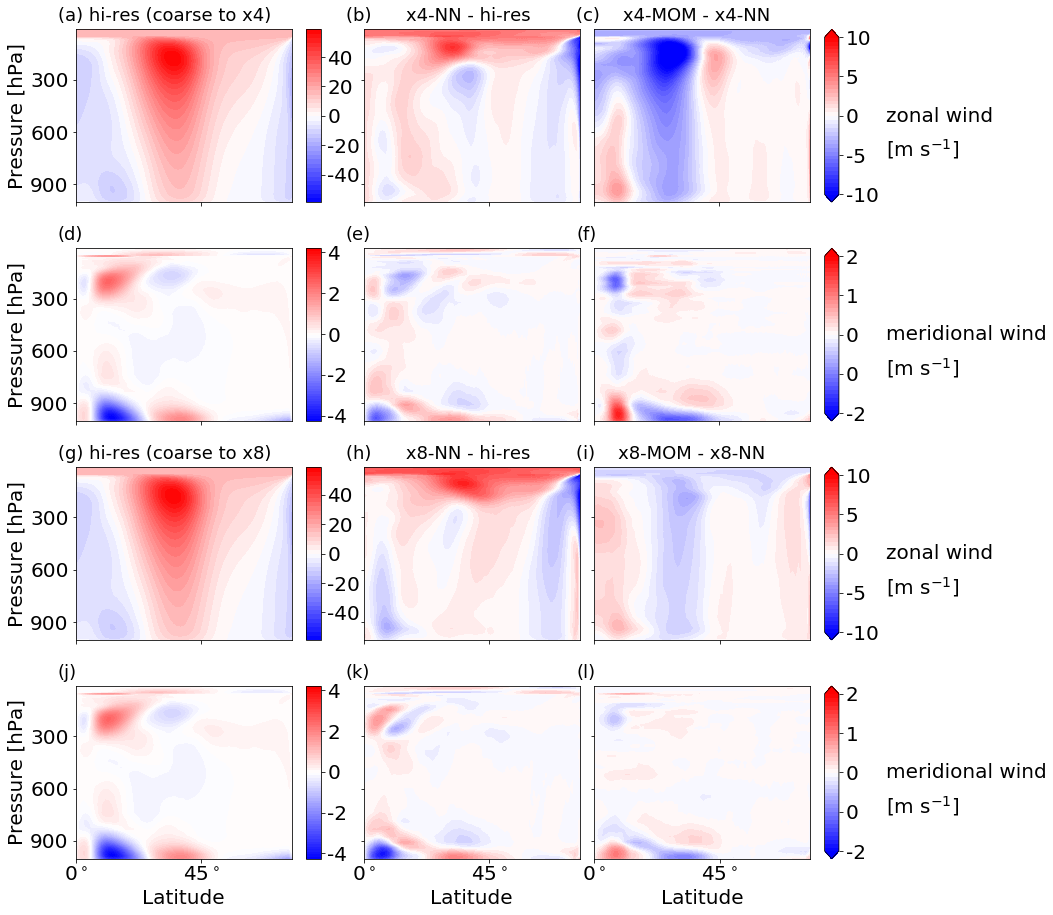

In [19]:
plot_RMSE_plot_U_V_2_resolutions_3_panels_1_hemisphere(x4_hires,x4_reference,x4_NN,x4_MOM,x4_MOM['y'],x4_MOM['p'],
               x8_hires,x8_reference,x8_NN,x8_MOM,x8_MOM['y'],x8_MOM['p'],save=False,save_name='U_V_x4_x8_3_panels_1_hemisphere.eps')